# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Effects-of-HIF-1-on-mitochondrial-proteins" data-toc-modified-id="Effects-of-HIF-1-on-mitochondrial-proteins-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Effects of HIF-1 on mitochondrial proteins</a></div><div class="lev1 toc-item"><a href="#HIF-1-effects-on-the-ribosome" data-toc-modified-id="HIF-1-effects-on-the-ribosome-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>HIF-1 effects on the ribosome</a></div><div class="lev1 toc-item"><a href="#Bioenergetics-of-HIF-1" data-toc-modified-id="Bioenergetics-of-HIF-1-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bioenergetics of HIF-1</a></div><div class="lev1 toc-item"><a href="#Effects-of-HIF-1-on-the-Proteasome-and-Mediator" data-toc-modified-id="Effects-of-HIF-1-on-the-Proteasome-and-Mediator-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Effects of HIF-1 on the Proteasome and Mediator</a></div><div class="lev2 toc-item"><a href="#Effect-of-HIF-1-on-proteins-involved-in-'protein-catabolic-process'" data-toc-modified-id="Effect-of-HIF-1-on-proteins-involved-in-'protein-catabolic-process'-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Effect of HIF-1 on proteins involved in 'protein catabolic process'</a></div><div class="lev1 toc-item"><a href="#Proteins-annotated-as-involved-in-protein-folding" data-toc-modified-id="Proteins-annotated-as-involved-in-protein-folding-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Proteins annotated as involved in protein folding</a></div><div class="lev1 toc-item"><a href="#Immune-Involvement" data-toc-modified-id="Immune-Involvement-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Immune Involvement</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# morgan
import morgan as morgan
import tissue_enrichment_analysis as tea

import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

import genpy
import seqplotter
import gvars
import epistasis as epi

In [2]:
q = 0.1
genvar = gvars.genvars()

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [4]:
thomas.filter_data(0, 0.1)

In [5]:
respiratory_complexes = pd.read_excel('../input/respiratory_complexes.xlsx')
central_dogma = pd.read_excel('../input/central_dogma.xlsx')

In [6]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [7]:
melted_tissue = pd.melt(tissue_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_tissue = melted_tissue[melted_tissue.expressed == 1]

melted_phenotype = pd.melt(phenotype_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_phenotype = melted_phenotype[melted_phenotype.expressed == 1]

melted_go = pd.melt(go_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_go = melted_go[melted_go.expressed == 1]

In [8]:
frames = []
for key, df in thomas.beta.items():
    genotype = genvar.fancy_mapping[key]
    df['code'] = key
    df['genotype'] = genotype
    df['sort_order'] = genvar.plot_order[genotype]
    df['abs_b'] = df.b.abs()
    frames += [df]

In [9]:
tidy_data = pd.concat(frames)
tidy_data.sort_values('sort_order', inplace=True)

# drop the fog-2 data:
tidy_data = tidy_data[tidy_data.code != 'g']
tidy_data = tidy_data[tidy_data.qval < q]  # keep only sig data.

In [10]:
def gene_compactifier(ext_gene):
    """Given a list of ext_gene names, compactify them and print"""
    
    d = {}
    ext_gene = sorted(ext_gene)
    for gene in ext_gene:
        ind = gene.find('-')
        if ind > 1:
            name = gene[:ind]
            number = gene[ind+1:]
        else:
            name = gene
            number = ''

        if name in d.keys():
            d[name] += [number]
        else:
            d[name] = [number]
    
    print('Gene "Family", Number Found')
    for name, numbers in d.items():
        if len(numbers) > 1:
            print(name + ', ', len(numbers), sorted(numbers))
        else:
            if len(numbers[0]) > 0:
                print(name + '-' + numbers[0])
            else:
                print(name)

# Effects of HIF-1 on mitochondrial proteins

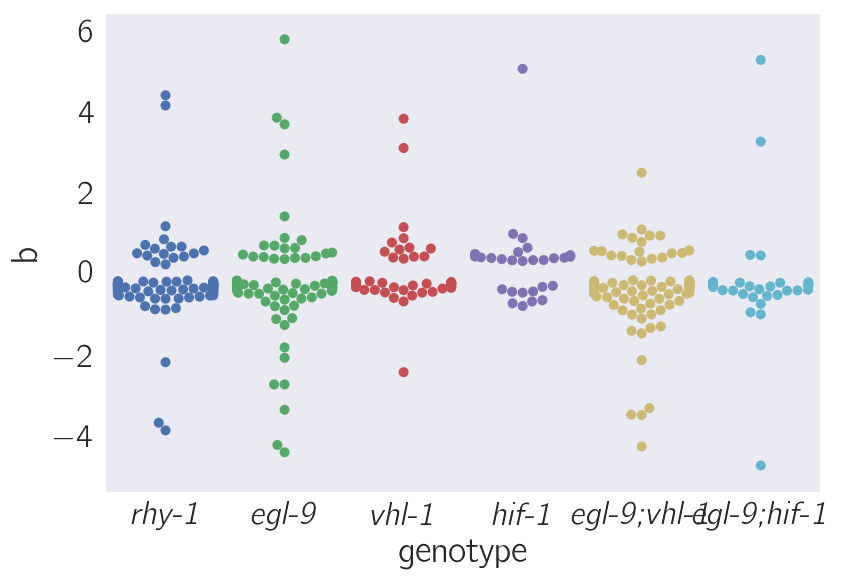

In [61]:
ax, mito = seqplotter.plot_by_term('mitochondrion', df=tidy_data, kind='go', swarm=True)

In [70]:
common  = epi.find_overlap(['e', 'b', 'd', 'a'], tidy_data)
trial = tidy_data[(tidy_data.ens_gene.isin(mito)) & (tidy_data.target_id.isin(common)) &
                  (tidy_data.b > 0)].ext_gene
gene_compactifier(trial)

Gene "Family", Number Found
oxa-1
pcca,  4 ['1', '1', '1', '1']
sdha,  4 ['1', '1', '1', '1']
fum,  8 ['1', '1', '1', '1', '1', '1', '1', '1']
mai,  4 ['1', '1', '1', '1']
F20D6.11
acl,  5 ['6', '6', '6', '6', '6']


In [69]:
trial = tidy_data[(tidy_data.ens_gene.isin(mito)) & (tidy_data.target_id.isin(common)) &
                  (tidy_data.b < 0)].ext_gene
gene_compactifier(trial)

Gene "Family", Number Found
sucg,  4 ['1', '1', '1', '1']
T02G5.7,  4 ['', '', '', '']
F02A9.4,  4 ['', '', '', '']
Y38F1A.6,  5 ['', '', '', '', '']
timm,  4 ['23', '23', '23', '23']
oxa,  4 ['1', '1', '1', '1']
ZK1320.9,  4 ['', '', '', '']
F54D5.12,  6 ['', '', '', '', '', '']
mrpl,  4 ['9', '9', '9', '9']
B0272.3,  4 ['', '', '', '']
pdhb,  4 ['1', '1', '1', '1']
icd,  4 ['1', '1', '1', '1']
R07E5.13,  5 ['', '', '', '', '']
cyc,  4 ['1', '1', '1', '1']
sucl,  4 ['1', '1', '1', '1']
pcca-1
wah,  5 ['1', '1', '1', '1', '1']
Y53G8AL.2,  4 ['', '', '', '']
F20D6.11,  5 ['', '', '', '', '']
mdh,  4 ['2', '2', '2', '2']
acdh,  5 ['1', '1', '1', '1', '1']
Y54F10AM.5,  4 ['', '', '', '']
hsp,  5 ['60', '60', '60', '60', '60']
sco,  4 ['1', '1', '1', '1']
Y48A6B.3,  4 ['', '', '', '']


# HIF-1 effects on the ribosome

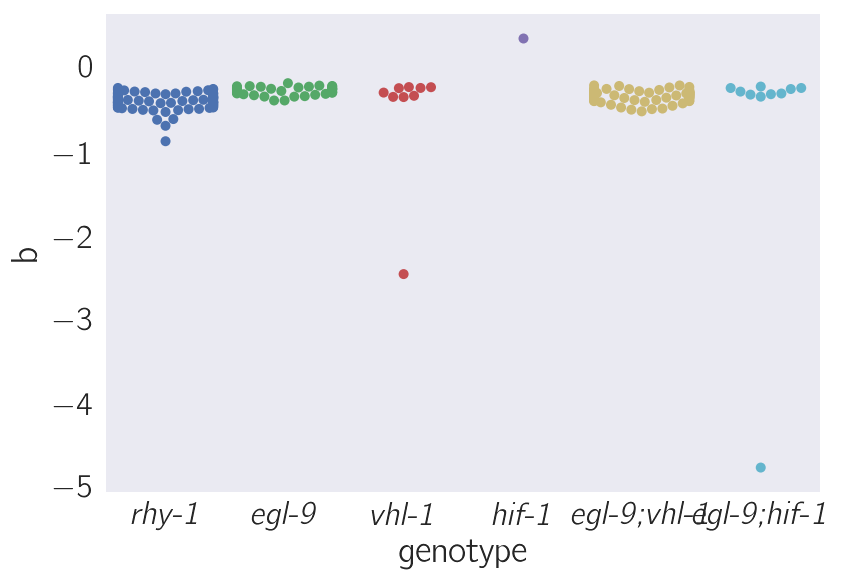

In [14]:
ax, ribosome = seqplotter.plot_by_term('structural constituent of ribosome GO:0003735', df=tidy_data, kind='go')

In [15]:
trial = tidy_data[(tidy_data.ens_gene.isin(ribosome)) & (tidy_data.qval < q)].ext_gene.unique()
gene_compactifier(trial)

Gene "Family", Number Found
T07A9.14
mrps,  9 ['14', '17', '18C', '22', '25', '34', '35', '6', '7']
Y37E3.8
rpl,  34 ['1', '10', '11.1', '11.2', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24.1', '24.2', '25.2', '26', '27', '28', '3', '30', '32', '33', '34', '35', '4', '5', '6', '7', '9']
ubl-1
C37A2.7
rps,  24 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '30', '4', '5', '6', '7', '8', '9']
mrpl,  12 ['10', '11', '12', '13', '16', '17', '19', '2', '24', '47', '51', '9']
dap-3
rla,  3 ['0', '1', '2']
ubq-2


# Bioenergetics of HIF-1

In [37]:
resp = tidy_data[tidy_data.ens_gene.isin(respiratory_complexes.ens_gene) 
                 & (~tidy_data.code.isin(['f', 'c']))].copy()
resp['complex'] = resp.ens_gene.map(lambda x: 
                                    respiratory_complexes[respiratory_complexes.ens_gene == x].complex.values[0])
resp['sort_order'] = resp.ens_gene.map(lambda x: 
                                       respiratory_complexes[respiratory_complexes.ens_gene == x].sort_order.values[0])
resp.sort_values('sort_order', inplace=True)
resp = resp[resp.complex != 'Ubiquinone Biosynthesis']

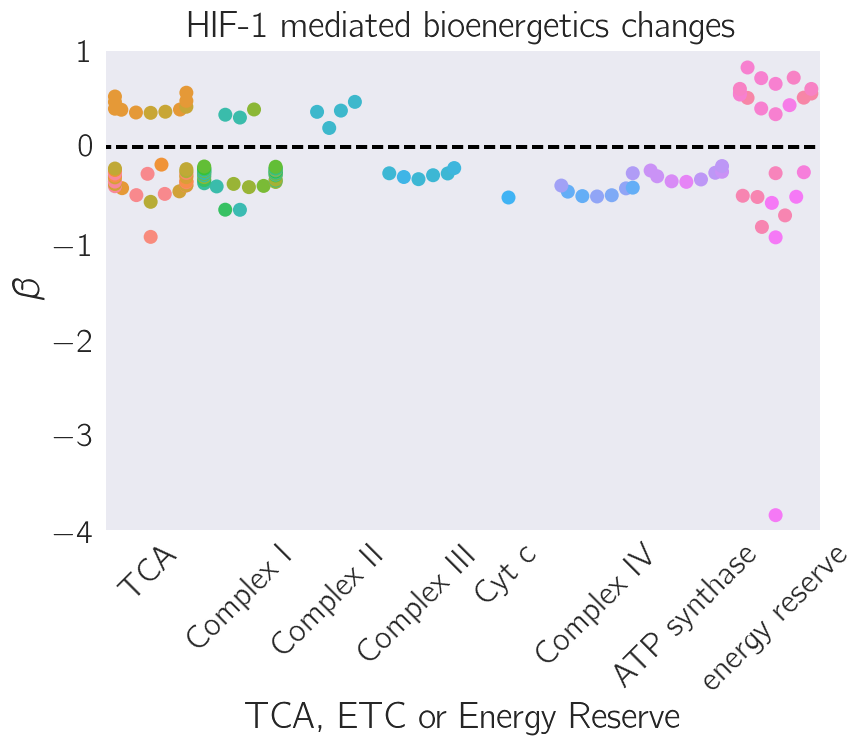

In [71]:
fig, ax = plt.subplots()
ax = sns.swarmplot(x='complex', y='b', hue='ens_gene', data=resp, size=7)
plt.xticks(rotation=45)
ax.legend_.remove()
plt.title('HIF-1 mediated bioenergetics changes')
plt.ylabel(r'\beta')
plt.xlabel('TCA, ETC or Energy Reserve')
ax.hlines(0, xmin=-2, xmax=10, lw=2, linestyle='--')
plt.ylim(-4, 1)
plt.savefig('../output/mito_function.pdf')

In [72]:
gene_compactifier(resp[(resp.complex == 'Complex I') & (resp.b < 0)].ext_gene)

Gene "Family", Number Found
nduo,  4 ['1', '1', '2', '4']
djr-1.1
C25H3.9,  2 ['', '']
gas,  2 ['1', '1']
nuo,  8 ['1', '1', '1', '2', '4', '6', '6', '6']
F53F4.10,  2 ['', '']
Y53G8AL.2,  4 ['', '', '', '']
F45H10.3,  3 ['', '', '']
Y54F10AM.5,  4 ['', '', '', '']
F59C6.5
T20H4.5
nduf,  3 ['7', '7', '7']


In [73]:
gene_compactifier(resp[(resp.complex == 'Complex I') & (resp.b > 0)].ext_gene)

Gene "Family", Number Found
nduo-4
nuo,  2 ['2', '2']


In [74]:
gene_compactifier(resp[(resp.complex == 'Complex II') & (resp.b < 0)].ext_gene)

Gene "Family", Number Found


In [75]:
gene_compactifier(resp[(resp.complex == 'Complex II') & (resp.b > 0)].ext_gene)

Gene "Family", Number Found
sdha,  4 ['1', '1', '1', '1']


In [77]:
gene_compactifier(resp[(resp.complex == 'TCA') & (resp.b < 0)].ext_gene)

Gene "Family", Number Found
sucg,  4 ['1', '1', '1', '1']
dlst,  2 ['1', '1']
suca,  3 ['1', '1', '1']
idha,  2 ['1', '1']
idh-2
mdh,  4 ['2', '2', '2', '2']
icl-1
idhg-1
cts,  2 ['1', '1']
fum-1
sucl,  4 ['1', '1', '1', '1']
aco,  3 ['1', '1', '1']


In [78]:
gene_compactifier(resp[(resp.complex == 'TCA') & (resp.b > 0)].ext_gene)

Gene "Family", Number Found
mdh,  3 ['1', '1', '1']
fum,  8 ['1', '1', '1', '1', '1', '1', '1', '1']


In [51]:
gene_compactifier(resp[(resp.complex == 'energy reserve') & (resp.b > 0)].ext_gene)

Gene "Family", Number Found
ogt,  3 ['1', '1', '1']
T22F3.3,  7 ['', '', '', '', '', '', '']
aagr,  2 ['1', '1']
H18N23.2
T04A8.7,  3 ['', '', '']


In [50]:
gene_compactifier(resp[(resp.complex == 'energy reserve') & (resp.b < 0)].ext_gene)

Gene "Family", Number Found
R05F9.6
aagr,  8 ['1', '1', '1', '1', '2', '2', '2', '2']
gsy-1


# Effects of HIF-1 on the Proteasome and Mediator

In [18]:
prot = tidy_data[tidy_data.ens_gene.isin(central_dogma.ens_gene)].copy()
prot['complex'] = prot.ens_gene.map(lambda x: central_dogma[central_dogma.ens_gene == x].complex.values[0])

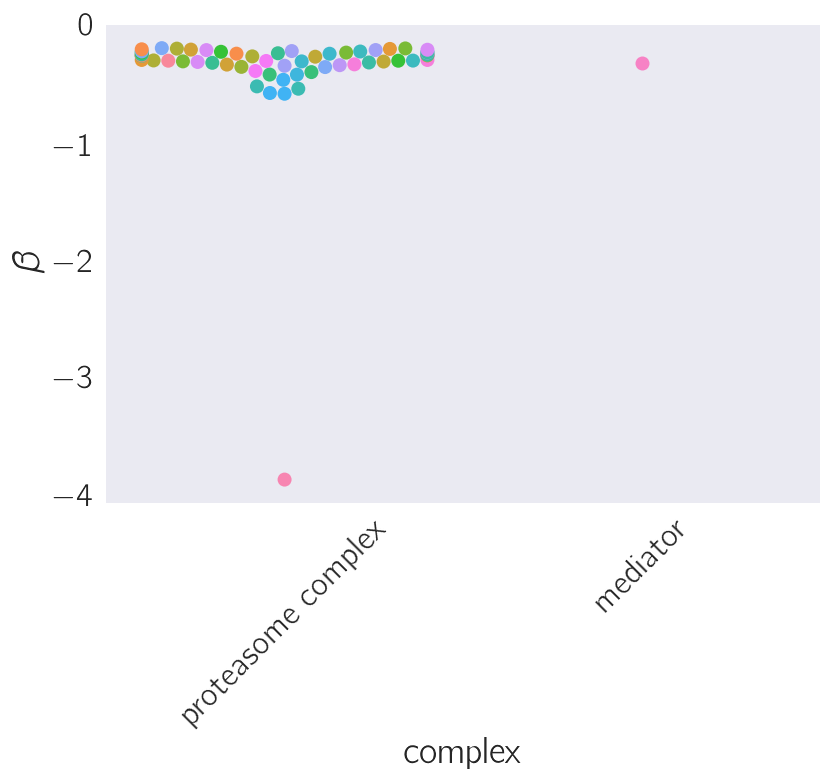

In [19]:
fig, ax = plt.subplots()
ax = sns.swarmplot(x='complex', y='b', hue='ens_gene', data=prot, size=7)
plt.xticks(rotation=45)
ax.legend_.remove()
# plt.title('HIF-1 mediated changes in ETC expression')
plt.ylabel(r'\beta')
# plt.xlabel('Electron Transport Chain Complexes')

## Effect of HIF-1 on proteins involved in 'protein catabolic process'
This GO term includes proteins that are involved in protein degradation, including the proteasome, a variety of ubiquitin-related enzymes and proteases

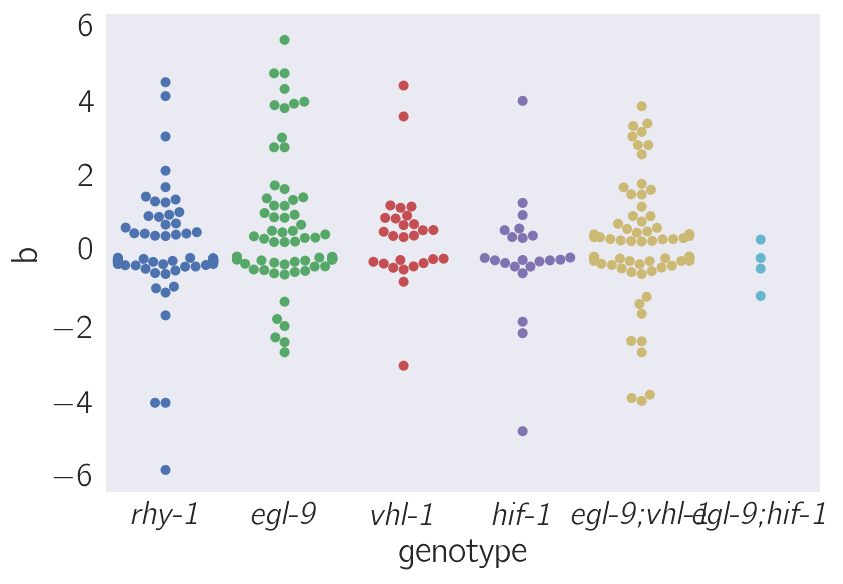

In [20]:
ax, negregproteolysis = seqplotter.plot_by_term('protein catabolic process GO:0030163',
                                                df=tidy_data, kind='go')

In [21]:
temp = tidy_data[(tidy_data.ens_gene.isin(negregproteolysis)) &
                 (tidy_data.target_id.isin(common)) &
                 (tidy_data.b > 0)
                ].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
F13D12.6
ctsa-2
K10C2.1
cpr,  2 ['1', '3']
zyx-1
asp,  2 ['5', '8']
uev-3


In [22]:
temp = tidy_data[(tidy_data.ens_gene.isin(negregproteolysis)) &
                 (tidy_data.target_id.isin(common)) &
                 (tidy_data.b < 0)
                ].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
cpl-1
ubq-2
Y119C1B.5
pbs-4
asp-8
cpz-1
ubc-20


# Proteins annotated as involved in protein folding

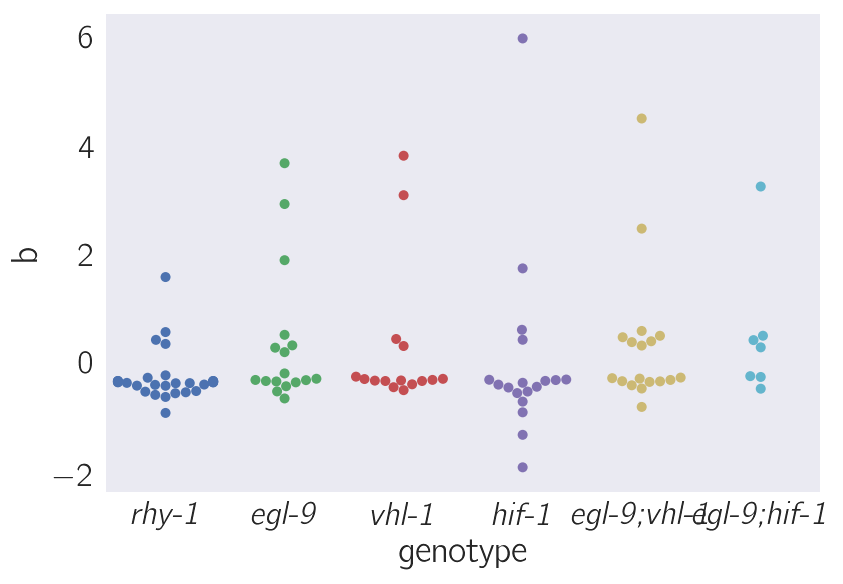

In [23]:
ax, folding = seqplotter.plot_by_term('protein folding', df=tidy_data, kind='go')

In [24]:
temp = tidy_data[(tidy_data.ens_gene.isin(folding)) & (tidy_data.b > 0)].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
cyn,  3 ['5', '6', '8']
hsp,  2 ['6', '60']
C34C12.8
ZK973.11
F42G8.7
C03H12.1
Y49E10.4
daf-21
enpl-1
fkb-4
T10H10.2


In [25]:
temp = tidy_data[(tidy_data.ens_gene.isin(folding)) & (tidy_data.b < 0)].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
cyn,  5 ['1', '2', '3', '5', '7']
pfd,  4 ['1', '2', '4', '5']
dpy-11
txl-1
catp-6
daf-21
Y22D7AL.10
cct,  3 ['1', '3', '7']
nud-1
hsp,  2 ['6', '60']
C34C12.8
dnj,  3 ['12', '13', '19']
cdc-37
fkb,  3 ['1', '2', '6']


# Immune Involvement

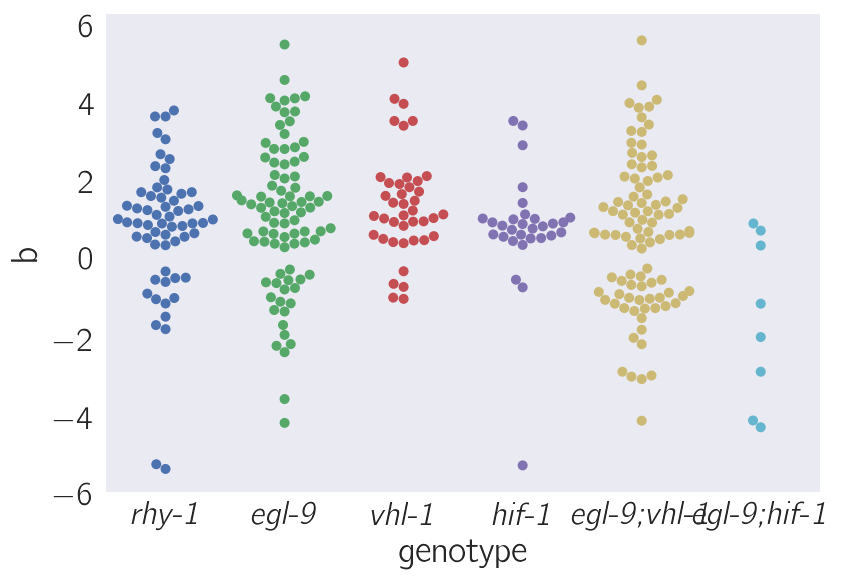

In [26]:
ax, immune = seqplotter.plot_by_term('immune system process', df=tidy_data, kind='go')

In [27]:
temp = tidy_data[(tidy_data.ens_gene.isin(immune)) & (tidy_data.target_id.isin(common)) &
                 (tidy_data.b > 0)].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
C34H4.2
F55G11.2
F01D5.5
C49C3.9
C25D7.5
dod-24
gst-7
fos-1
F01D5.1
nhr-57
cpr-3
Y41D4B.17
dct-17
clec,  4 ['210', '66', '70', '72']


In [28]:
temp = tidy_data[(tidy_data.ens_gene.isin(immune)) & (tidy_data.target_id.isin(common)) &
                 (tidy_data.b < 0)].ext_gene.unique()
gene_compactifier(temp)

Gene "Family", Number Found
F55G11.2
cyp-35A5
acdh-1
aqp-10
